In [1]:
# LSTM and HW implementations refer to:
# https://github.com/thowan/predictive-autoscaler/blob/master/kube/online/offline-2methods.py
# Author of LSTM and HW implementations: Thomas Wang(thowan)

import pymongo
import math
import os
import operator
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings('ignore')

In [2]:
# convert cpu unit 'n' to 'm'
def convert_cpu(x):
    if x != 0:
        if x[-1] == 'n':
            return round(int(x[:-1])/1000000)
        elif x[-1] == 'm':
            return int(x[:-1])
    else:
        return 0
    
# convert memory unit 'k' and 'Ki' to 'Mi'
# 1k = 1000/1024 Ki = 1000/1024**2 Mi
def convert_mem(x):
    if x != 0:
        if x[-1] == 'k':
            return round(int(x[:-1])*1000/1024**2)
        elif x[-2:] == 'Ki':
            return round(int(x[:-2])/1024)
        elif x[-2:] == 'Mi':
            return int(x[:-2])
    else:
        return 0

In [3]:
def get_data(db_name):
    #mongodb
    mongoclient = pymongo.MongoClient("mongodb://localhost:27017/")
    db = mongoclient[db_name]
    print(db.name)
    
    #data process
    collist = db.list_collection_names()
    vpa = pd.DataFrame(list(db['vpa'].find()))
    vpa['time'] = pd.to_datetime(vpa['time'],unit='s').round('1s')
    record = {}
    collist = ['usage', 'requests']
    for col in collist:
        record[col] = pd.DataFrame(list(db[col].find()))
        # convert timestamp to time
        record[col]['time'] = pd.to_datetime(record[col]['time'],unit='s').round('1s')
        record[col]['cpu'] = record[col]['cpu'].apply(lambda x: convert_cpu(x))
        record[col]['cpu'] = record[col]['cpu'].fillna(0)
    vpa['target_cpu'] = vpa['target_cpu'].apply(lambda x: convert_cpu(x))
    usage = record['usage']
    usage = usage[usage['pod_name'] == usage.iloc[0]['pod_name']]
    usage=usage[['time','cpu']]
    vpa = vpa[['time','target_cpu']]
    result = pd.merge(usage, vpa, how='right', on="time")
    result['cpu'] = result['cpu'].fillna(0)
    return result.time, result.cpu, result.target_cpu

In [4]:
def split_sequence(sequence, n_steps_in, n_steps_out, ywindow):
    X, y = list(), list()

    for i in range(len(sequence)-ywindow-n_steps_in+1):
        # find the end of this pattern
        end_ix = i + n_steps_in

        # gather input and output parts of the pattern
        # print(sequence[end_ix:end_ix+ywindow])
        seq_x, seq_y = sequence[i:end_ix], [np.percentile(sequence[end_ix:end_ix+ywindow], 90), np.percentile(sequence[end_ix:end_ix+ywindow], 60), np.percentile(sequence[end_ix:end_ix+ywindow], 98)]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [5]:
def trans_foward(arr):
    global scaler
    out_arr = scaler.transform(arr.reshape(-1, 1))
    return out_arr.flatten()

def trans_back(arr):
    global scaler
    out_arr = scaler.inverse_transform(arr.flatten().reshape(-1, 1))
    return out_arr.flatten()

In [6]:
def create_lstm(n_steps_in, n_steps_out, n_features,raw_seq, ywindow):
    global scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(raw_seq.reshape(-1, 1))
    #print("First 10 of raw_seq:", raw_seq[:20])
    dataset = trans_foward(raw_seq)
    # split into samples
    X, y = split_sequence(dataset, n_steps_in, n_steps_out, ywindow)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # define model
    model = Sequential()
    
    # Multi-layer model 
    model.add(LSTM(50, return_sequences=True , input_shape=(n_steps_in, n_features)))
    # model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))

    # Single layer model
    # model.add(LSTM(100, input_shape=(n_steps_in, n_features)))

    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=10, verbose=0)
    
    return model

In [7]:
def lstm_predict(input_data,model,n_steps_in,n_features): 
    x_input = np.array(trans_foward(input_data))
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    return trans_back(yhat)

In [8]:
def calc_n(i, season_len, history_len):
    season = math.ceil((i+1)/season_len)
    history_start_season = season - (history_len/season_len)
    if history_start_season < 1:
        history_start_season = 1
    history_start = (history_start_season-1) * season_len 
    n = int(i - history_start)
    return n

In [9]:
def HW_LSTM(series):
    HW_target, HW_upper, HW_lower = 90, 98, 60
    lstm_target, lstm_upper, lstm_lower = 90, 98, 60
    
    season_len = 60
    history_len = season_len * 3
    scaling_start_index = season_len * 2

    window_past = 1
    window_future = 24

    i = scaling_start_index
    rescale_buffer = 120
    rescale_cooldown = 18
    lstm_cooldown = 0
    hw_cooldown = 0

    model = None
    hw_model = None
    steps_in, steps_out, n_features, ywindow = 48, 3, 1, 24

    lstm_CPU_request = 250
    hw_CPU_request =250

    lstm_requests = [lstm_CPU_request] * scaling_start_index
    lstm_targets = []
    lstm_uppers = []
    lstm_lowers = []

    hw_requests = [hw_CPU_request] * scaling_start_index
    hw_targets = []
    hw_uppers = []
    hw_lowers = []

    while i <= len(series):
        series_part = series[:i]
        n = calc_n(i, season_len, history_len)
    
        #HW model
        if i % 60 == 0 or hw_model is None:
            hw_model = ExponentialSmoothing(series_part[-n:], trend="add", seasonal="add", seasonal_periods=season_len)
            model_fit = hw_model.fit()
        
        hw_window = model_fit.predict(start=n-window_past,end=n+window_future)
        hw_target = np.percentile(hw_window, HW_target)
        hw_lower = np.percentile(hw_window, HW_lower)
        hw_upper = np.percentile(hw_window, HW_upper)
        if hw_target < 0:
            hw_target = 0
        if hw_lower < 0:
            hw_lower = 0
        if hw_upper < 0:
            hw_upper = 0
        hw_targets.append(hw_target)
        hw_uppers.append(hw_upper)
        hw_lowers.append(hw_lower)
    
        #LSTM model
        if i % 60 == 0 or model is None:
            model = create_lstm(steps_in, steps_out, n_features, series_part, ywindow)
    
        input_data = np.array(series_part[-steps_in:])
        output_data = lstm_predict(input_data, model, steps_in, n_features)
    
        lstm_target = output_data[0]
        lstm_lower = output_data[1]
        lstm_upper = output_data[2]
        if lstm_target < 0:
            lstm_target = 0
        if lstm_lower < 0:
            lstm_lower = 0
        if lstm_upper < 0:
            lstm_upper = 0
        lstm_targets.append(lstm_target)
        lstm_uppers.append(lstm_upper)
        lstm_lowers.append(lstm_lower)
    
        # HW scaling 
        hw_CPU_request_unbuffered = hw_CPU_request - rescale_buffer
        # If no cool-down
        if (hw_cooldown == 0):
            # If request change greater than 50
            if (abs(hw_CPU_request - (hw_target + rescale_buffer)) > 50):
                # If above upper
                if hw_CPU_request_unbuffered > hw_upper:
                    hw_CPU_request = hw_target + rescale_buffer
                    hw_cooldown = rescale_cooldown
            # elseIf under lower
                elif hw_CPU_request_unbuffered < hw_lower: 
                    hw_CPU_request = hw_target + rescale_buffer
                    hw_cooldown = rescale_cooldown

        # Reduce cooldown 
        if hw_cooldown > 0:
            hw_cooldown -= 1

        hw_requests.append(hw_CPU_request)

        # LSTM scaling
        lstm_CPU_request_unbuffered = lstm_CPU_request - rescale_buffer
        
        # If no cool-down
        if (lstm_cooldown == 0):
            # If request change greater than 50
            if (abs(lstm_CPU_request - (lstm_target + rescale_buffer)) > 50):
                # If above upper
                if lstm_CPU_request_unbuffered > lstm_upper:
                    lstm_CPU_request = lstm_target + rescale_buffer
                    lstm_cooldown = rescale_cooldown
                # elseIf under lower
                elif lstm_CPU_request_unbuffered < lstm_lower: 
                    lstm_CPU_request = lstm_target + rescale_buffer
                    lstm_cooldown = rescale_cooldown

        # Reduce cooldown 
        if lstm_cooldown > 0:
            lstm_cooldown -= 1

        lstm_requests.append(lstm_CPU_request)
    
    
        i += 1
    return hw_requests, lstm_requests

In [10]:
def plot_curve(dbname, time, cpu, target_cpu, lstm_requests, hw_requests):
    fig, ax = plt.subplots(1,1,figsize=(15,5),sharex=True,sharey=True)
    ax.plot(time, cpu,label='CPU Usage Demand',color='r')
    ax.plot(time, target_cpu,label=dbname,color='b',linestyle='--')
    ax.plot(time, lstm_requests[:len(time)],label='LSTM',color='g',linestyle='-.')
    ax.plot(time, hw_requests[:len(time)],label='HW',color='c',linestyle='-')
    ax.set_ylabel('CPU [millicores]', fontsize=25)
    ax.set_xlabel('Time', fontsize=25)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator())
#     fig.autofmt_xdate() #rotate labels
    ax.legend(fontsize=21, loc='upper center', ncol=4, shadow=True,bbox_to_anchor=(0.5, -0.2))
    plt.yticks(size = 25)
    plt.xticks(size = 25)
    plt.grid(True, linestyle='-.')
#     plt.show()
    home = os.path.expanduser('~')
    folder = '{}/coldstart'.format(home)
    if not os.path.exists(folder):
        os.makedirs(folder)
    plt.savefig('{}/coldstart_{}.png'.format(folder, dbname),bbox_inches='tight')

In [11]:
def evaluate(usage, prediction):
    slack = list(map(operator.sub, prediction, usage))
    slack_total = 0
    insufficient_count = 0
    insufficient_total = 0
    for i in slack:
        if i < 0:
            insufficient_count += 1
            insufficient_total += abs(i)
        else:
            slack_total += i
    return '%0.2f'%(slack_total/len(usage)), '%0.2f'%(insufficient_total/len(usage))

image_rotate_shorter_ema5-3
video_processing_17m_ema5-3


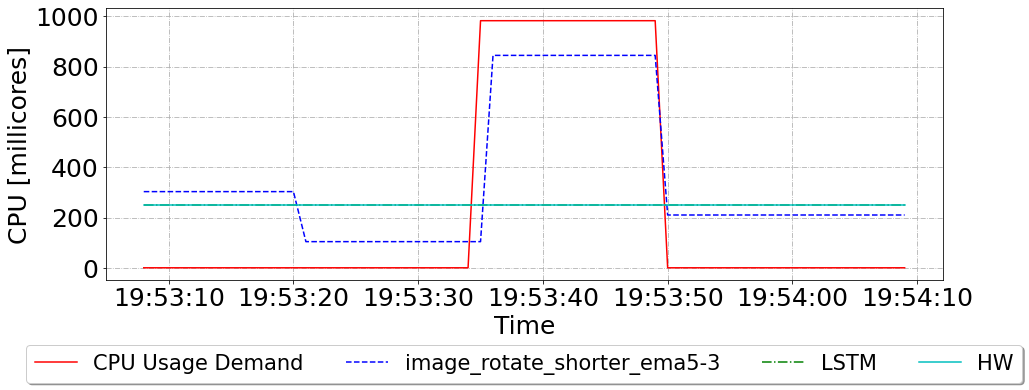

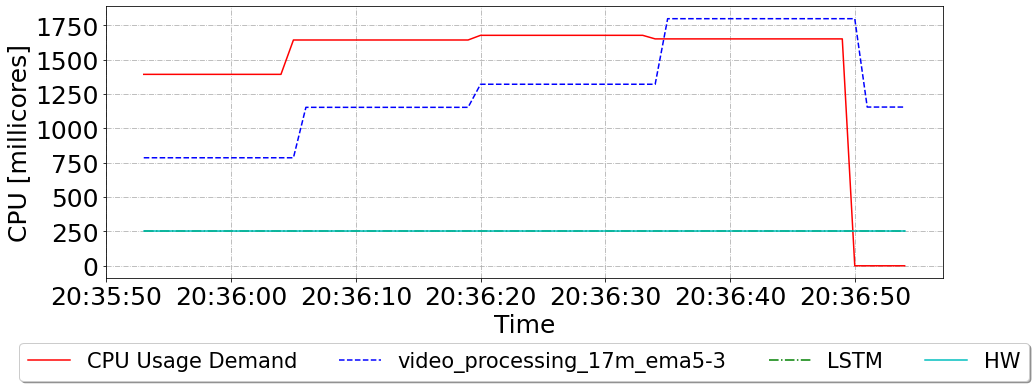

In [12]:
db_names = ['image_rotate_shorter_ema5-3','video_processing_17m_ema5-3']
for db in db_names:
    time, cpu, target_cpu = get_data(db)
    series = np.array(cpu)
    hw_requests, lstm_requests = HW_LSTM(series)
    plot_curve(db, time[:60], cpu[:60], target_cpu[:60], lstm_requests[:60], hw_requests[:60])

In [13]:
def evaluate_coldstart():
    mongoclient = pymongo.MongoClient("mongodb://localhost:27017/")
    evaluate_dict = {}
    for db_name in ['image_rotate_shorter_ema5-3','image_rotate_shorter_default','video_processing_17m_ema5-3']:
        time, cpu, target_cpu = get_data(db_name)
        slack, insufficient = evaluate(cpu[:60], target_cpu[:60])
        evaluate_dict[db_name] = []
        evaluate_dict[db_name].append(float(slack))
        evaluate_dict[db_name].append(float(insufficient))
    for db_name in ['image_rotate_shorter_sma10-5','image_rotate_shorter_sma5-3','video_processing_17m_sma5-3','video_processing_17m_default']:
        time, cpu, target_cpu = get_data(db_name)
        slack, insufficient = evaluate(cpu[:30], target_cpu[:30])
        evaluate_dict[db_name] = []
        evaluate_dict[db_name].append(float(slack))
        evaluate_dict[db_name].append(float(insufficient))
    for db_name in ['image_rotate_shorter_sma3-2','image_rotate_shorter_ema3-2','image_rotate_shorter_default1s','image_rotate_shorter_ema10-5',
                    'video_processing_17m_ema3-2','video_processing_17m_ema10-5','video_processing_17m_sma3-2','video_processing_17m_default1s']:
        time, cpu, target_cpu = get_data(db_name)
        slack, insufficient = evaluate(cpu[:40], target_cpu[:40])
        evaluate_dict[db_name] = []
        evaluate_dict[db_name].append(float(slack))
        evaluate_dict[db_name].append(float(insufficient))
    for db_name in ['video_processing_17m_sma10-5']:
        time, cpu, target_cpu = get_data(db_name)
        slack, insufficient = evaluate(cpu[:80], target_cpu[:80])
        evaluate_dict[db_name] = []
        evaluate_dict[db_name].append(float(slack))
        evaluate_dict[db_name].append(float(insufficient))
    return evaluate_dict

In [14]:
evaluate_dict = evaluate_coldstart()
videodict = {k: v for k, v in evaluate_dict.items() if k.startswith('video_processing')}
imagedict = {k: v for k, v in evaluate_dict.items() if k.startswith('image_rotate_shorter')}

image_rotate_shorter_ema5-3
image_rotate_shorter_default
video_processing_17m_ema5-3
image_rotate_shorter_sma10-5
image_rotate_shorter_sma5-3
video_processing_17m_sma5-3
video_processing_17m_default
image_rotate_shorter_sma3-2
image_rotate_shorter_ema3-2
image_rotate_shorter_default1s
image_rotate_shorter_ema10-5
video_processing_17m_ema3-2
video_processing_17m_ema10-5
video_processing_17m_sma3-2
video_processing_17m_default1s
video_processing_17m_sma10-5


In [15]:
def plot_histogram(evaluate_dict, cpu, lstm_requests, hw_requests):
    lstm, hw = [],[]
    lstm = evaluate(cpu[:60], lstm_requests[:60])
    hw = evaluate(cpu[:60], hw_requests[:60])
    labels,slack,insuf = [],[],[]
    for i in evaluate_dict:
        labels.append(i.split('_')[-1])
        slack.append(float(evaluate_dict.get(i)[0]))
        insuf.append(float(evaluate_dict.get(i)[1]))
    slack.append(float(lstm[0]))
    insuf.append(float(lstm[1]))
    slack.append(float(hw[0]))
    insuf.append(float(hw[1]))
    labels.append('LSTM')
    labels.append('HW')
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(19, 5))
    ax[0].bar(labels, slack, color="steelblue", alpha=0.25, edgecolor="black")
    ax[1].bar(labels, insuf, color="lightcoral", alpha=0.25, edgecolor="black")
    
    ax[0].tick_params(axis='x', labelrotation = 45, labelsize = 22)
    ax[1].tick_params(axis='x', labelrotation = 45, labelsize = 22)
    ax[0].tick_params(axis='y', labelsize = 22)
    ax[1].tick_params(axis='y', labelsize = 22)

    ax[0].set_ylabel("Avg. Slack [millicores]",  fontsize=25)
    ax[1].set_ylabel("Avg. Insuf. CPU [millicores]", fontsize=25)
    home = os.path.expanduser('~')
    folder = '{}/coldstart'.format(home)
    if not os.path.exists(folder):
        os.makedirs(folder)
    dbname = list(evaluate_dict.keys())[0]
    plt.savefig('{}/coldstart_{}.png'.format(folder, '_'.join(dbname.split('_')[:-1])),bbox_inches='tight')

image_rotate_shorter_ema5-3


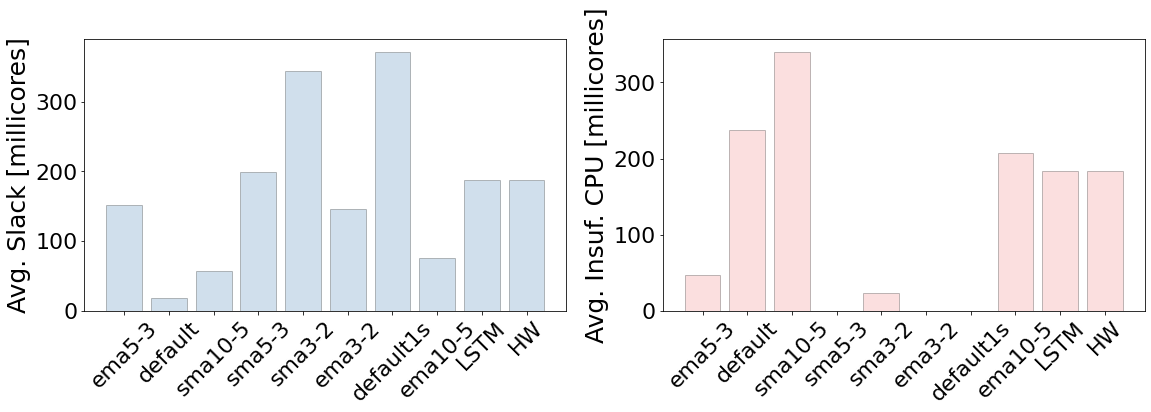

In [16]:
cpu_usage = 'image_rotate_shorter_ema5-3'
time, cpu, target_cpu = get_data(cpu_usage)
series = np.array(cpu)
hw_requests, lstm_requests = HW_LSTM(series)
plot_histogram(imagedict, cpu, lstm_requests, hw_requests)

video_processing_17m_ema5-3


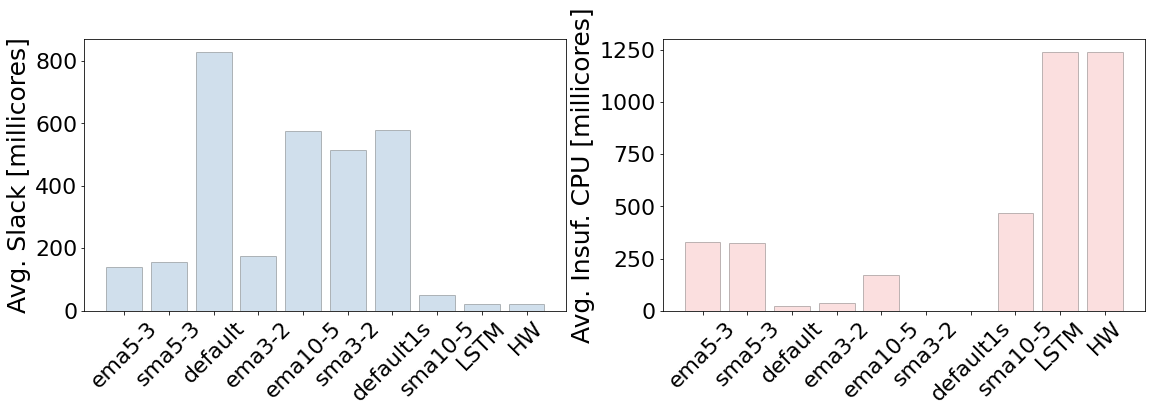

In [17]:
cpu_usage = 'video_processing_17m_ema5-3'
time, cpu, target_cpu = get_data(cpu_usage)
series = np.array(cpu)
hw_requests, lstm_requests = HW_LSTM(series)
plot_histogram(videodict, cpu, lstm_requests, hw_requests)